In [1]:
import pandas as pd
import numpy as np
import pylab
import math

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# Set default matplot figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) 

In [2]:
# set seed
np.random.seed(123)

In [3]:
#Tree packages for checking the feature importance
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier() 

In [4]:
credit = pd.read_csv("C:\\Users\\Jeroen\\Desktop\\Ubiqum\\Data Science\\Excel Files\\Credit_1.csv", header = 0)
credit = credit[credit.columns[2:len(credit.columns)]]

In [5]:
#There are some bills that are negative. Here the customer has paid off too much. 
#What makes it more weird is that many of these are predicted to default the next month.
#Since you cannot default on a bill if you dont have owe any money, i'll make some adjustments to these values 
credit.CUR_BIL_SEP[credit.CUR_BIL_SEP < 0] = 0
credit.CUR_BIL_AUG[credit.CUR_BIL_AUG < 0] = 0
credit.CUR_BIL_JULY[credit.CUR_BIL_JULY < 0] = 0
credit.CUR_BIL_JUNE[credit.CUR_BIL_JUNE < 0] = 0
credit.CUR_BIL_MAY[credit.CUR_BIL_MAY < 0] = 0
credit.CUR_BIL_APR[credit.CUR_BIL_APR < 0] = 0

In [6]:
#Remove the values that had no debt in september but were given a default status in october
credit = credit[-((credit.CUR_BIL_SEP == 0) & (credit.DEFAULT == 'Defaults'))]

In [7]:
credit.head()

,CREDIT,SEX,EDUCATION,MARRIAGE,AGE,PAYSTAT_APR,PAYSTAT_MAY,PAYSTAT_JUNE,PAYSTAT_JULY,PAYSTAT_AUG,...,CUR_BIL_JULY,CUR_BIL_AUG,CUR_BIL_SEP,PAID_APR,PAID_MAY,PAID_JUNE,PAID_JULY,PAID_AUG,PAID_SEP,DEFAULT
0,20000,Female,University,Single,24,-2,-2,-1,-1,2,...,689,3102,3913,0,0,0,0,689,0,Defaults
1,120000,Female,University,Married,26,2,0,0,0,2,...,2682,1725,2682,2000,0,1000,1000,1000,0,Defaults
2,90000,Female,University,Married,34,0,0,0,0,0,...,13559,14027,29239,5000,1000,1000,1000,1500,1518,Pays
3,50000,Female,University,Single,37,0,0,0,0,0,...,49291,48233,46990,1000,1069,1100,1200,2019,2000,Pays
4,50000,Male,University,Single,57,0,0,0,-1,0,...,35835,5670,8617,679,689,9000,10000,36681,2000,Pays


In [8]:
#Genereate arrays that give the average increase of the bill
BILL_INCR_MAY = credit.CUR_BIL_MAY/(credit.CUR_BIL_MAY + credit.CUR_BIL_APR)
BILL_INCR_JUN = credit.CUR_BIL_JUNE/(credit.CUR_BIL_JUNE + credit.CUR_BIL_MAY)
BILL_INCR_JUL = credit.CUR_BIL_JULY/(credit.CUR_BIL_JULY + credit.CUR_BIL_JUNE)
BILL_INCR_AUG = credit.CUR_BIL_AUG/(credit.CUR_BIL_AUG + credit.CUR_BIL_JULY)
BILL_INCR_SEP = credit.CUR_BIL_SEP/(credit.CUR_BIL_SEP + credit.CUR_BIL_AUG)

#replace NaN by 1 (since it was caused by 0/0)
BILL_INCR_MAY[np.isnan(BILL_INCR_MAY)]  = 1
BILL_INCR_JUN[np.isnan(BILL_INCR_JUN)]  = 1
BILL_INCR_JUL[np.isnan(BILL_INCR_JUL)]  = 1
BILL_INCR_AUG[np.isnan(BILL_INCR_AUG)]  = 1
BILL_INCR_SEP[np.isnan(BILL_INCR_SEP)]  = 1

credit["AVG_BILL_INCR"] = (BILL_INCR_MAY + 
                           BILL_INCR_JUN + 
                           BILL_INCR_JUL +
                           BILL_INCR_AUG + 
                           BILL_INCR_SEP) / 5

In [9]:
credit.AVG_BILL_INCR[credit.AVG_BILL_INCR > 100] = 100
credit.AVG_BILL_INCR[credit.AVG_BILL_INCR < -100] = -100
credit.AVG_BILL_INCR.describe()

D:\Users\Jeroen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Users\Jeroen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    29357.000000
mean         0.553608
std          0.125354
min          0.237637
25%          0.494419
50%          0.512252
75%          0.560590
max          1.000000
Name: AVG_BILL_INCR, dtype: float64

In [10]:
#Make a variable that states whether the person has defaulted in the past
credit['DEFAULTED_BEFORE'] = (np.where((credit['PAYSTAT_APR'] >= 1) |
                                       (credit['PAYSTAT_MAY'] >= 1) |
                                       (credit['PAYSTAT_JUNE'] >= 1) |
                                       (credit['PAYSTAT_JULY'] >= 1) |
                                       (credit['PAYSTAT_AUG'] >= 1) |
                                       (credit['PAYSTAT_SEP'] >= 1)
                                       , "Yes" , "No"))

print("Of the people that will default in October,",
      (len(credit[((credit.DEFAULT == "Defaults") & (credit.DEFAULTED_BEFORE == "Yes"))]) / 
      len(credit[credit.DEFAULT == "Defaults"]))*100,
      "percent has defaulted at least once in the previous months as well.")

Of the people that will default in October, 64.05806774570331 percent has defaulted at least once in the previous months as well.


In [11]:
#Create variable that provides ratio of current bill and amount that can be borrowed
credit['CREDIT_RATIO'] = (credit['CUR_BIL_AUG'] / credit['CREDIT'])

#Check for the difference in the ratio people that default and people that pay
defaulters = credit[credit.DEFAULT == "Defaults"]
nondefaulters = credit[credit.DEFAULT == "Pays"]

print("Average credit ratio is", credit.CREDIT_RATIO.mean())
print("Average credit ratio for defaulters is", defaulters.CREDIT_RATIO.mean())
print("Average credit ratio for non-defaulters is", nondefaulters.CREDIT_RATIO.mean())

Average credit ratio is 0.4200665362091719
Average credit ratio for defaulters is 0.5370995924117704
Average credit ratio for non-defaulters is 0.39004688607126126


(array([1.254e+04, 3.563e+03, 4.396e+03, 2.718e+03, 6.200e+01, 4.400e+01,
        2.500e+01, 6.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.      , 0.319025, 0.63805 , 0.957075, 1.2761  , 1.595125,
        1.91415 , 2.233175, 2.5522  , 2.871225, 3.19025 , 3.509275,
        3.8283  , 4.147325, 4.46635 , 4.785375, 5.1044  , 5.423425,
        5.74245 , 6.061475, 6.3805  ]),
 <a list of 20 Patch objects>)

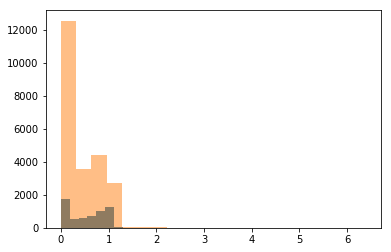

In [12]:
plt.hist(defaulters.CREDIT_RATIO, bins = 20)
plt.hist(nondefaulters.CREDIT_RATIO, bins = 20, alpha = 0.5)

In [13]:
#convert all categories into numerical variables so they can be proberly used to model with
credit.SEX = pd.CategoricalIndex(credit.SEX)
credit.EDUCATION = pd.CategoricalIndex(credit.EDUCATION)
credit.MARRIAGE = pd.CategoricalIndex(credit.MARRIAGE)
credit.DEFAULT = pd.CategoricalIndex(credit.DEFAULT)
credit.DEFAULTED_BEFORE = pd.CategoricalIndex(credit.DEFAULTED_BEFORE)

credit['SEX'] = credit.SEX.cat.codes
credit['EDUCATION'] = credit.EDUCATION.cat.codes
credit['MARRIAGE'] = credit.MARRIAGE.cat.codes
credit['DEFAULT'] = credit.DEFAULT.cat.codes
credit['DEFAULTED_BEFORE'] = credit.DEFAULTED_BEFORE.cat.codes

In [14]:
credit.head()

,CREDIT,SEX,EDUCATION,MARRIAGE,AGE,PAYSTAT_APR,PAYSTAT_MAY,PAYSTAT_JUNE,PAYSTAT_JULY,PAYSTAT_AUG,...,PAID_APR,PAID_MAY,PAID_JUNE,PAID_JULY,PAID_AUG,PAID_SEP,DEFAULT,AVG_BILL_INCR,DEFAULTED_BEFORE,CREDIT_RATIO
0,20000,0,3,2,24,-2,-2,-1,-1,2,...,0,0,0,0,689,0,0,0.875212,1,0.155100
1,120000,0,3,0,26,2,0,0,0,2,...,2000,0,1000,1000,1000,0,0,0.490259,1,0.014375
2,90000,0,3,0,34,0,0,0,0,0,...,5000,1000,1000,1000,1500,1518,1,0.530010,0,0.155856
3,50000,0,3,2,37,0,0,0,0,0,...,1000,1069,1100,1200,2019,2000,1,0.522509,0,0.964660
4,50000,1,3,2,57,0,0,0,-1,0,...,679,689,9000,10000,36681,2000,1,0.478699,0,0.113400


In [15]:
#Split the data in a train and testset
credit_dep = credit.DEFAULT
credit_indep = credit.drop(['DEFAULT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(credit_indep, credit_dep, test_size=0.3)

In [28]:
len(credit_indep)
len(credit_dep)


29357

In [17]:
# Build a forest and compute the feature importances
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)


D:\Users\Jeroen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.814827429609446

In [18]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print(feature_importances)

                  importance
PAYSTAT_SEP         0.099587
PAYSTAT_AUG         0.061432
CUR_BIL_SEP         0.059985
CREDIT_RATIO        0.056920
AVG_BILL_INCR       0.051342
AGE                 0.047088
CUR_BIL_JULY        0.044770
CUR_BIL_AUG         0.044625
PAID_AUG            0.043019
PAID_SEP            0.042064
CUR_BIL_JUNE        0.041973
PAID_JULY           0.040855
CUR_BIL_MAY         0.040832
CUR_BIL_APR         0.040575
PAID_APR            0.039831
PAID_MAY            0.039575
PAID_JUNE           0.038953
CREDIT              0.038389
PAYSTAT_APR         0.020081
PAYSTAT_JULY        0.019573
PAYSTAT_JUNE        0.019567
DEFAULTED_BEFORE    0.018572
PAYSTAT_MAY         0.017597
EDUCATION           0.013859
MARRIAGE            0.009540
SEX                 0.009395


In [19]:
#Generate dummies for PAYSTAT_SEP since this variable has most explanatory power over the independent var
September_dummies = pd.get_dummies(credit.PAYSTAT_SEP)
September_dummies.columns = ["No_payment", "Paid_in_time", "Paid_partly", 
                             "1_month_late", "2_months_late", "3_months_late", 
                             "4_months_late", "5_months_late", "6_months_late", 
                             "7_months_late", "8_months_late"]
September_dummies["4>_months_late"] = (September_dummies["4_months_late"] +
                                       September_dummies["5_months_late"] +
                                       September_dummies["6_months_late"] +
                                       September_dummies["7_months_late"] +
                                       September_dummies["8_months_late"])


In [20]:
#Generate dummies for PAYSTAT_AUG 
August_dummies = pd.get_dummies(credit.PAYSTAT_AUG)
August_dummies.columns = ["Aug_No_payment", "Aug_Paid_in_time", "Aug_Paid_partly", 
                             "Aug_1_month_late", "Aug_2_months_late", "Aug_3_months_late", 
                             "Aug_4_months_late", "Aug_5_months_late", "Aug_6_months_late", 
                             "Aug_7_months_late", "Aug_8_months_late"]

August_dummies["4>_months_late"] = (August_dummies["Aug_4_months_late"] +
                                       August_dummies["Aug_5_months_late"] +
                                       August_dummies["Aug_6_months_late"] +
                                       August_dummies["Aug_7_months_late"] +
                                       August_dummies["Aug_8_months_late"])


In [21]:
#Add dataframes together
New_credit = pd.concat([credit, September_dummies, August_dummies], axis = 1)

In [22]:
#Keep only the variables that seem important and are not overly correlated with each other
credit = New_credit[["CUR_BIL_SEP", "PAID_SEP", "CREDIT", "CREDIT_RATIO", "AGE", "No_payment", "Paid_in_time", "Paid_partly", 
                             "1_month_late", "2_months_late", "3_months_late", 
                             "4_months_late", "5_months_late", "6_months_late", 
                             "7_months_late", "8_months_late", "DEFAULT"]]

#split dep and independent variables again for standardization
credit_dep = credit.DEFAULT
credit_indep = credit.drop(['DEFAULT'], axis=1)

In [23]:
#standardize the data
from sklearn import preprocessing

# Get column names
names = credit_indep.columns

#scale the data
scaled_credit = pd.DataFrame(preprocessing.scale(credit_indep))

#return columnnames
scaled_credit.columns = names

D:\Users\Jeroen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


In [24]:
#Restore row index to make combining the dataframes easier
credit_dep.index = range(len(credit_dep))


In [25]:
#add the dataframes together
credit = scaled_credit
credit["DEFAULT"] = credit_dep

In [26]:
#See whether there are Na's due the scaling the dataframes
print(credit_indep.isnull().values.any())
print(credit_dep.isnull().values.any())

print(scaled_credit.isnull().values.any())
print(credit.isnull().values.any())

False
False
False
False


In [27]:
# Save the dataframe and create a new 
credit.to_csv("C:\\Users\\Jeroen\\Desktop\\Ubiqum\\Data Science\\Excel Files\\Credit_3.csv")